In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import utils as ut
import matplotlib.pyplot as plt

from sklearn import preprocessing

from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
import sklearn.metrics

from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer

import pickle

from keras.wrappers.scikit_learn import KerasClassifier#------------------------------

from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY

import time
#import tensorflow_addons as tfa
inicio = time.time()
from sklearn.metrics import roc_curve

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

2022-06-18 15:01:25.767611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-18 15:01:25.767637: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
patience = 50
EPOCHS = 200
batch_size = 64
save_model = True
split_size = 10
dropna=False

t_aprendizado = 0.01
momentum = 0.26

In [3]:
PATH = '../data/water_potability.csv'
label_column='Potability'
have_classes=True
drop_columns_list=['Id']
drop_columns=True

df, df_one_hot, X, y, classes, columns = ut.clean_data(PATH=PATH, shuffle=True, label_column=label_column, drop_columns_list=drop_columns_list, drop_columns=drop_columns, have_classes=have_classes, dropna=dropna)
df

NaN = **1434** will be categorized under feature_nan columns
NaN = **1434** will be categorized under feature_nan columns


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
286,5.671774,216.042811,15949.153179,7.500573,NaN,372.535243,17.895724,77.457885,3.833160,1
1865,8.822610,216.432576,27109.239652,7.322163,NaN,384.018547,15.955491,78.828883,4.415596,0
1053,8.922410,207.520726,13291.922609,8.560537,357.944327,468.538326,15.692738,107.282329,4.081728,0
3154,7.951451,185.421724,6108.795734,7.117859,344.795681,283.877280,18.904399,85.799759,3.886882,1
322,7.798454,188.394942,32704.569286,11.078872,258.191184,507.178688,18.272439,85.177662,4.107267,1
...,...,...,...,...,...,...,...,...,...,...
1749,NaN,157.827352,21716.423692,5.406394,NaN,478.998973,18.928979,80.202845,3.825770,0
3158,8.182103,186.670496,19642.394421,7.715136,NaN,370.321395,11.521597,55.493882,4.605238,1
1480,7.066142,207.361429,22523.433570,8.064693,343.293876,503.253317,12.168334,83.656615,4.127599,1
2221,5.152740,185.342237,25669.719920,7.819479,318.450974,449.918993,18.301574,49.342036,3.842625,0


In [4]:
X =  preprocessing.scale(X, with_mean='False')
y = np.array(y)
X = np.array(X)

imputer = KNNImputer()
imputer.fit(X)
X = imputer.transform(X)

2022-06-18 15:01:29.124782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-18 15:01:29.124812: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-18 15:01:29.124834: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lasid30): /proc/driver/nvidia/version does not exist
2022-06-18 15:01:29.125268: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


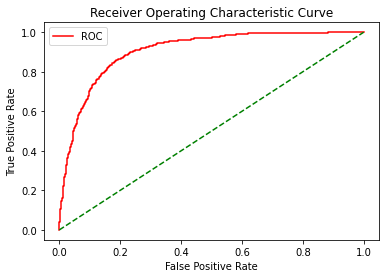

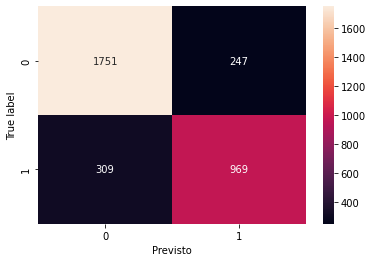

1  

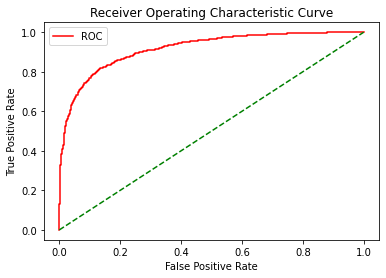

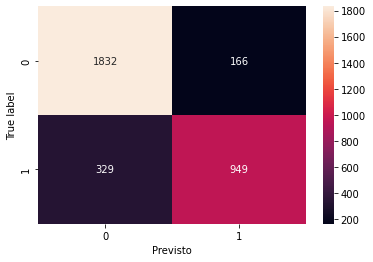

2  

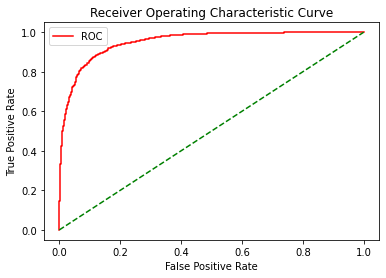

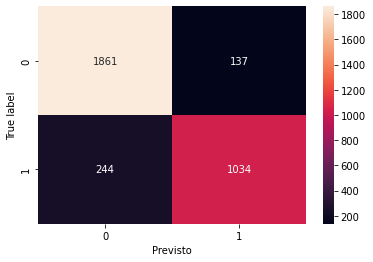

3  

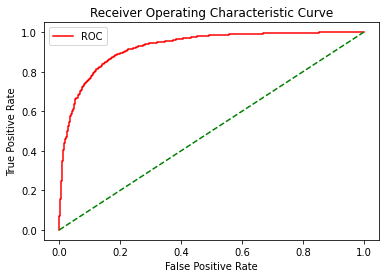

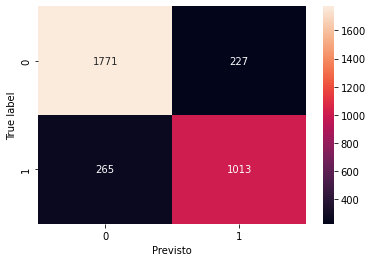

4  

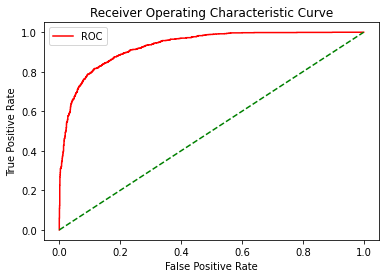

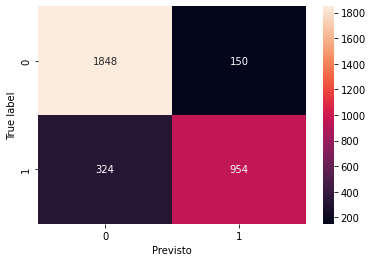

5  

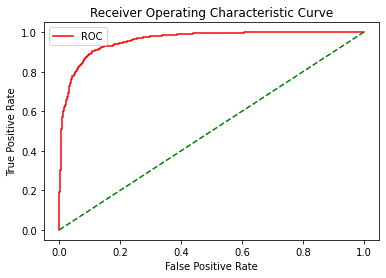

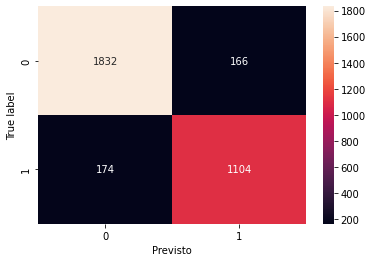

6  

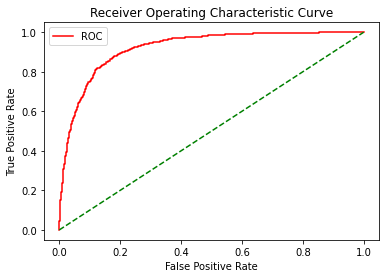

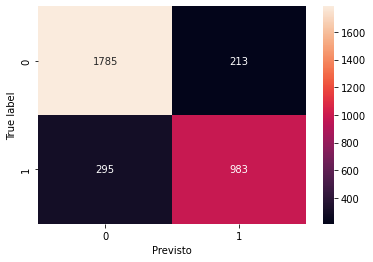

7  

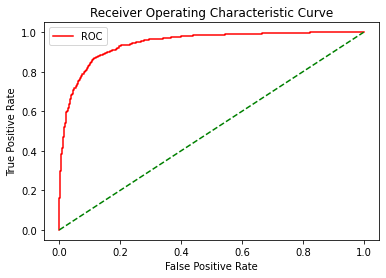

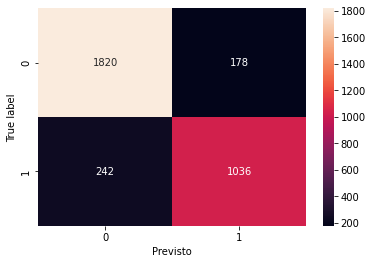

8  

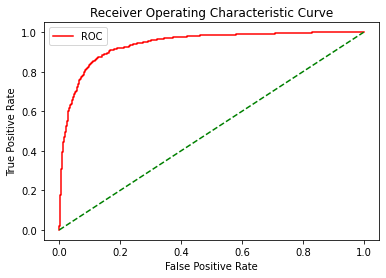

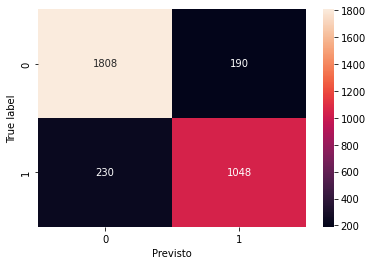

9  

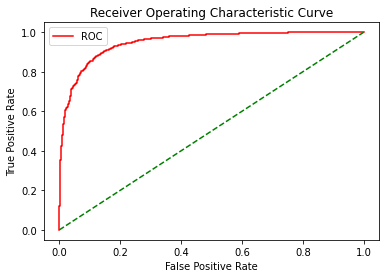

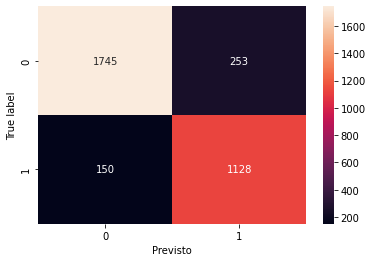

10  

In [5]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.4),
    
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.1),

    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

earlystopper = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, verbose=0)

opt=tf.keras.optimizers.SGD(learning_rate=t_aprendizado, momentum=momentum)
#opt = 'adam'
#opt = tf.keras.optimizers.RMSprop()
#opt = 'rmsprop'#<---

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

#history = model.fit (X, y, validation_split=0.1, batch_size=batch_size, epochs=EPOCHS, callbacks=[earlystopper], verbose=0)

results = []
results.append(['predicoes','predicoes_val','train_acc','train_pre','train_rec','train_f1','val_acc','val_pre','val_rec','val_f1'])

#table = PrettyTable( ['id','train_acc','train_pre','train_rec','train_f1','val_acc','val_pre','val_rec','val_f1'] )
table = PrettyTable( ['K-Fold','train_acc','val_acc',  'train_rec','val_rec',  'train_pre','val_pre',  'train_f1','val_f1'] )
i=0

kf = KFold(n_splits=split_size)

for train_idx, val_idx in  kf.split(X, y) :

    train_x = X[train_idx]
    train_y = y[train_idx]
    val_x = X[val_idx]
    val_y = y[val_idx]
    
    model.fit (train_x, train_y, validation_data=(val_x, val_y), batch_size=batch_size, epochs=EPOCHS, callbacks=[earlystopper], verbose=0)
    
    predicoes_train = model.predict(train_x)
    predicoes_train = predicoes_train > 0.5
    
    acc = sklearn.metrics.accuracy_score(y_true = train_y , y_pred = predicoes_train)
    pre = sklearn.metrics.precision_score(y_true = train_y, y_pred = predicoes_train)
    rec = sklearn.metrics.recall_score(y_true = train_y   , y_pred = predicoes_train)
    f1 = sklearn.metrics.f1_score(y_true = train_y        , y_pred = predicoes_train)


    predicoes_val = model.predict(val_x)
    predicoes_val = predicoes_val > 0.5
    
    val_acc = sklearn.metrics.accuracy_score(y_true = val_y,  y_pred = predicoes_val)
    val_pre = sklearn.metrics.precision_score(y_true = val_y, y_pred = predicoes_val)
    val_rec = sklearn.metrics.recall_score(y_true = val_y,    y_pred = predicoes_val)
    val_f1 = sklearn.metrics.f1_score(y_true = val_y,         y_pred = predicoes_val)
    
    i+=1
    table.add_row( [i,   acc, val_acc,     rec, val_rec,    pre, val_pre,     f1, val_f1] )

    results.append([ predicoes_train, predicoes_val, acc, pre, rec, f1, val_acc, val_pre, val_rec, val_f1])


    proba = model.predict(X) 

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=y, y_score=proba)
    plot_roc_curve(fpr_keras, tpr_keras)
    
    
    proba = proba > 0.5
    confusion_mtx = confusion_matrix(y, proba)
    #plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels=['0','1'], yticklabels=['0','1'], annot=True, fmt='g')
    plt.xlabel('Previsto')
    plt.ylabel('True label')
    plt.show()
    
    
    print(f'{i}  ',end='')

In [6]:
print(table)

+--------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
| K-Fold |     train_acc      |      val_acc       |     train_rec      |       val_rec       |     train_pre      |      val_pre       |      train_f1      |       val_f1       |
+--------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|   1    | 0.8514246947082768 | 0.6402439024390244 | 0.7945804195804196 | 0.44776119402985076 | 0.8174460431654677 | 0.5769230769230769 | 0.8058510638297873 | 0.5042016806722689 |
|   2    | 0.8483717774762551 | 0.8536585365853658 | 0.7450980392156863 |  0.7142857142857143 | 0.8551859099804305 | 0.8064516129032258 | 0.7963553530751708 | 0.7575757575757576 |
|   3    |  0.89280868385346  | 0.801829268292683  | 0.8218940052128584 |  0.6929133858267716 | 0.89

In [7]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              10240     
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

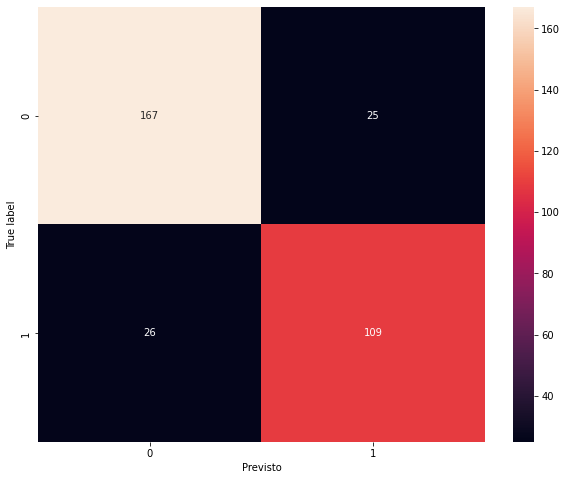

In [8]:
confusion_mtx = confusion_matrix(val_y, predicoes_val)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=['0','1'], yticklabels=['0','1'], annot=True, fmt='g')
plt.xlabel('Previsto')
plt.ylabel('True label')
plt.show()

In [9]:
if save_model:
    nome_saida = f'models/model | acc - {acc}.h5'
    #nome_saida = caminho_modelo+nome+'.h5'
    model.save(nome_saida)
    print('Salvo como: ',nome_saida)
print('Tempo de execução: ', time.time() - inicio)

Salvo como:  models/model | acc - 0.880637504238725.h5
Tempo de execução:  430.08223366737366
